# Don -  Classification Using CNN
## Goal:
Build a deep learning model to classify acne types using a CNN model, while addressing dataset imbalance through oversampling and augmentation.

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import Sequential, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling, TFSMLayer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import random
import numpy as np

import tarfile
import tensorflow_datasets as tfds
import stl10_input as STL

# Extract data first which creates a folder with the class names, fold_indices and binary data

In [4]:
extract_this = '/Users/doncheung/Desktop/AMSI/Assignment 2/stl10_binary.tar.gz'
tar = tarfile.open(extract_this, "r:gz")
tar.extractall()
tar.close()

/var/folders/8x/cmwt_bmn6c94q9zn4jqg68k40000gn/T/ipykernel_30373/3570907709.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


# Manually check and extract images

In [ ]:
### ONCE DOWNLOADED DON'T TOUCH AGAIN

# TRAIN_DATA_PATH = '/Users/doncheung/Desktop/AMSI/Assignment 2/stl10_binary/train_X.bin'
# TRAIN_LABEL_PATH = '/Users/doncheung/Desktop/AMSI/Assignment 2/stl10_binary/train_y.bin'

# # test to check if the image is read correctly
# with open(TRAIN_DATA_PATH) as f:
#     image = STL.read_single_image(f)
#     STL.plot_image(image)

# # test to check if the whole dataset is read correctly
# images = STL.read_all_images(TRAIN_DATA_PATH)
# print(images.shape)

# labels = STL.read_labels(TRAIN_LABEL_PATH)
# print(labels.shape)

# # save images to disk
# STL.save_images(images, labels)

In [ ]:
### ONCE DOWNLOADED DON'T TOUCH AGAIN

# TEST_DATA_PATH = '/Users/doncheung/Desktop/AMSI/Assignment 2/stl10_binary/test_X.bin'
# TEST_LABEL_PATH = '/Users/doncheung/Desktop/AMSI/Assignment 2/stl10_binary/test_y.bin'

# # test to check if the whole dataset is read correctly
# images = STL.read_all_images(TEST_DATA_PATH)
# print(images.shape)

# labels = STL.read_labels(TEST_LABEL_PATH)
# print(labels.shape)

# # save images to disk
# STL.save_images(images, labels)

In [36]:
train_dir = '/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER'
test_dir = '/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER'

# ----------------------------
# PARAMETERS
# ----------------------------
BATCH_SIZE = 32
IMAGE_SIZE = 128

# ----------------------------
# LOAD DATASETS
# ----------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=True
)

# valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     valid_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=BATCH_SIZE, shuffle=False
# )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='int', image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 5000 files belonging to 10 classes.
Found 8000 files belonging to 10 classes.
Classes: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


## 📊 6. Class Distribution

In [42]:
for folder in [train_dir, test_dir]:
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):  # Only count directories
            print(f"{folder}/{cls}:", len(os.listdir(cls_path)))

/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/9: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/7: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/6: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/1: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/10: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/8: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/4: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/3: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/2: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TRAIN_FOLDER/5: 500
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/9: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/7: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/6: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/1: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/10: 800
/Users/doncheung/Desktop/AMSI/Assignment 2/TEST_FOLDER/8: 

### 📌 Observation:
Categories evenly distributed

## ⚖️ 7. Compute Class Weights

In [ ]:
counts = [735, 645, 621, 584, 193]
classes = np.array([0,1,2,3,4])
y = np.repeat(classes, counts)
class_weight_dict = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y)))
print("Class weights:", class_weight_dict)

Class weights: {np.int64(0): np.float64(0.7559183673469387), np.int64(1): np.float64(0.8613953488372093), np.int64(2): np.float64(0.8946859903381642), np.int64(3): np.float64(0.9513698630136986), np.int64(4): np.float64(2.8787564766839377)}


## 🔧 8. Preprocessing & Normalization

In [43]:
### no normalisation needed here
# normalization_layer = Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (x, y))
# valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (x, y))

## 🔁 9. Data Augmentation

In [44]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15),
    RandomZoom(0.15)
])


## 🔄 10. Oversampling Minority Class (Whiteheads)

In [46]:
counts = 10*[500]

# Unbatch the dataset
train_ds_unbatched = train_ds.unbatch()

# Split dataset by class
class_datasets = []
for i in range(len(class_names)):
    class_datasets.append(train_ds_unbatched.filter(lambda x, y: y==i))

# Oversample minority class (Whiteheads, index 4)
target_count = max(counts)
minority_index = 4
repeat_times = target_count // counts[minority_index]
remainder = target_count % counts[minority_index]

oversampled_class = class_datasets[minority_index].repeat(repeat_times)
oversampled_class = oversampled_class.concatenate(class_datasets[minority_index].take(remainder))
class_datasets[minority_index] = oversampled_class

# Combine all classes
balanced_ds = class_datasets[0]
for ds in class_datasets[1:]:
    balanced_ds = balanced_ds.concatenate(ds)

# Shuffle, augment, and batch correctly
balanced_ds = balanced_ds.shuffle(5000)
balanced_ds = balanced_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
balanced_ds = balanced_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### ✅ Result: 
The dataset is now balanced across all acne types.

In [47]:
# valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

## 🧰 11. Build CNN Model

In [48]:
model = Sequential([
    Conv2D(32, (3,3), activation='tanh', input_shape=(IMAGE_SIZE, IMAGE_SIZE,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='tanh'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,490 (2.55 MB)

 Trainable params: 668,490 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️‍♂️ 12. Train Model


In [ ]:
# ----------------------------
# CALLBACKS
# ----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ----------------------------
# TRAIN MODEL
# ----------------------------
history = model.fit(
    balanced_ds,
    validation_data=test_ds, # test_ds instead of valid_ds
    epochs=50,
    # class_weight=class_weight_dict,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

Epoch 1/10


2026-01-29 23:59:24.951412: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


157/157 - 21s - 133ms/step - accuracy: 0.1420 - loss: 2.8946 - val_accuracy: 0.1171 - val_loss: 2.5974 - learning_rate: 0.0010
Epoch 2/10
157/157 - 22s - 138ms/step - accuracy: 0.1474 - loss: 2.7293 - val_accuracy: 0.1776 - val_loss: 2.3261 - learning_rate: 0.0010
Epoch 3/10


2026-01-30 00:00:08.287532: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


157/157 - 22s - 138ms/step - accuracy: 0.1456 - loss: 2.6236 - val_accuracy: 0.1632 - val_loss: 2.4082 - learning_rate: 0.0010
Epoch 4/10
157/157 - 21s - 135ms/step - accuracy: 0.1726 - loss: 2.4744 - val_accuracy: 0.2068 - val_loss: 2.2571 - learning_rate: 0.0010
Epoch 5/10
157/157 - 21s - 136ms/step - accuracy: 0.1762 - loss: 2.4093 - val_accuracy: 0.2432 - val_loss: 2.1734 - learning_rate: 0.0010
Epoch 6/10
157/157 - 20s - 129ms/step - accuracy: 0.2056 - loss: 2.2539 - val_accuracy: 0.2599 - val_loss: 2.1218 - learning_rate: 0.0010
Epoch 7/10


2026-01-30 00:01:33.045929: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


157/157 - 22s - 138ms/step - accuracy: 0.2294 - loss: 2.1818 - val_accuracy: 0.2855 - val_loss: 2.0538 - learning_rate: 0.0010
Epoch 8/10
157/157 - 21s - 137ms/step - accuracy: 0.2482 - loss: 2.1295 - val_accuracy: 0.3076 - val_loss: 1.9850 - learning_rate: 0.0010
Epoch 9/10
157/157 - 21s - 137ms/step - accuracy: 0.2720 - loss: 2.0496 - val_accuracy: 0.3210 - val_loss: 1.9523 - learning_rate: 0.0010
Epoch 10/10
157/157 - 20s - 130ms/step - accuracy: 0.2810 - loss: 2.0035 - val_accuracy: 0.2984 - val_loss: 1.9816 - learning_rate: 0.0010


## 📈 13. Evaluate Model

In [53]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.3210 - loss: 1.9523
Test Accuracy: 0.32100000977516174


## 🔍 14. Confusion Matrix & Classification Report

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true and predicted labels for test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

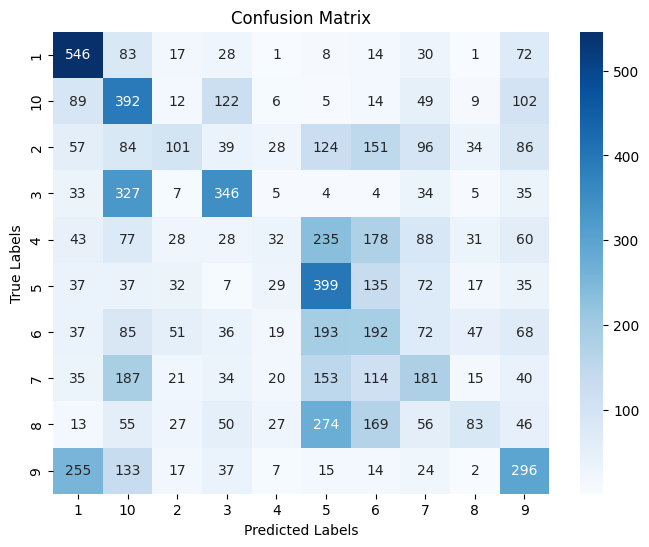

In [56]:
# ----------------------------
# CONFUSION MATRIX
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()



In [59]:
# ----------------------------
# CLASSIFICATION REPORT
# ----------------------------
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

           1       0.48      0.68      0.56       800
          10       0.27      0.49      0.35       800
           2       0.32      0.13      0.18       800
           3       0.48      0.43      0.45       800
           4       0.18      0.04      0.07       800
           5       0.28      0.50      0.36       800
           6       0.19      0.24      0.22       800
           7       0.26      0.23      0.24       800
           8       0.34      0.10      0.16       800
           9       0.35      0.37      0.36       800

    accuracy                           0.32      8000
   macro avg       0.32      0.32      0.29      8000
weighted avg       0.32      0.32      0.29      8000



## 📊 15. Accuracy and Loss Curves


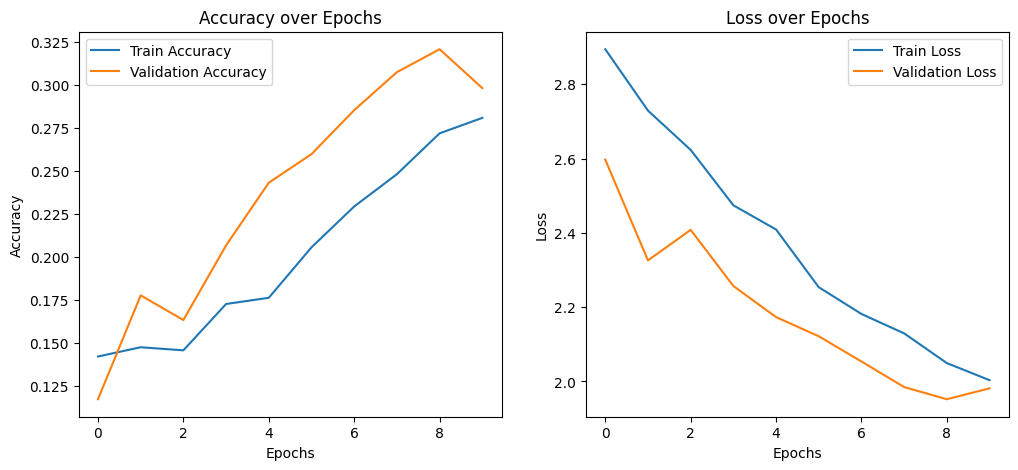

In [60]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()